Names: Aman Tewari, Ebaad Imran, Akin Bilen, Jake Medina

We have two main goals for this project, we will first attempt to predict where songs rank on the apple charts based on selected features. We want to approach this as a classification problem, as we care less about the exact ranking of a song, and more about how relatively popular it is going to be on the charts. Thus, we will split Apple rankings into 5 classes, apple_chart_category_276+,	apple_chart_category_1-50, apple_chart_category_51-100, apple_chart_category_101-200, apple_chart_category_201-275, and attempt to predict which class a given song falls under.

We specifically chose the apple chart because it appears to be a chart that doesn't only rank based on number of streams, the first cell of part 2 demostrates that there is only a rougly .38 correlation between average_streams_per_year and ranking, implying there are other factors that apple chooses to use to rank songs, and we want to explore what they are, or at least what we need to predict them.

The second goal of the project is much more ambitious, we wish to predict roughly the stream ranking of a song based on only features that would be given pre-release, i.e. we can't use features like in_spotify_playlists which describes how many spotify playlists contain the song. This would be very useful because it would create a model that producer could use to engineer a song that is "supposed" to top charts and honestly probably what happens in the industry today. Note: we chose streams_ranking rather than streams because the variance in the stream data is extremely high, and is will have more unusual patterns than stream_ranking. Of course, we would need much more training data to do this with a hypothetical song, but it's a good proof of concept.

All cells either have comments of markdown cells explaining their purpose or interpreting results. We ran cross-validation checks on almost all of our models, as well as tried techniques like bagging, boosting, and even switch models all together to improve accuracy. Furthermore, there are some models use that weren't discussed in class, but helped us improve our results.

Part 1: Data Collection, Cleanup, Feature Engineering (Combining Correlated Features)

In [ ]:
# ML Project

# headers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

Overiew of our data, the column names are very descriptive but we have included a description of each column:

track_name: Name of the song

artist(s)_name: Name of the artist(s) of the song

artist_count: Number of artists contributing to the song

released_year: Year when the song was released

released_month: Month when the song was released

released_day: Day of the month when the song was released

in_spotify_playlists: Number of Spotify playlists the song is included in

in_spotify_charts: Presence and rank of the song on Spotify charts

streams: Total number of streams on Spotify

in_apple_playlists: Number of Apple Music playlists the song is included in

in_apple_charts: Presence and rank of the song on Apple Music charts

in_deezer_playlists: Number of Deezer playlists the song is included in

in_deezer_charts: Presence and rank of the song on Deezer charts

in_shazam_charts: Presence and rank of the song on Shazam charts

bpm: Beats per minute, a measure of song tempo

key: Key of the song

mode: Mode of the song (major or minor)

danceability_%: Percentage indicating how suitable the song is for dancing

valence_%: Positivity of the song's musical content

energy_%: Perceived energy level of the song

acousticness_%: Amount of acoustic sound in the song

instrumentalness_%: Amount of instrumental content in the song

liveness_%: Presence of live performance elements

speechiness_%: Amount of spoken words in the song

In [ ]:
raw_data = pd.read_csv("spotify-2023.csv", skipinitialspace = True)
# raw_data.drop(raw_data['in_shazam_charts'], axis=1, inplace=True)
print(raw_data.head())
#print(raw_data.columns)

                            track_name    artist(s)_name  artist_count  \
0  Seven (feat. Latto) (Explicit Ver.)  Latto, Jung Kook             2   
1                                 LALA       Myke Towers             1   
2                              vampire    Olivia Rodrigo             1   
3                         Cruel Summer      Taylor Swift             1   
4                       WHERE SHE GOES         Bad Bunny             1   

   released_year  released_month  released_day  in_spotify_playlists  \
0           2023               7            14                   553   
1           2023               3            23                  1474   
2           2023               6            30                  1397   
3           2019               8            23                  7858   
4           2023               5            18                  3133   

   in_spotify_charts    streams  in_apple_playlists  ...  bpm key   mode  \
0                147  141381703               

Let's check for missing values

In [ ]:
print(raw_data.info())


missing_values = raw_data.isna().sum()
print(missing_values)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    int64 
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

It seems that there are some blank values in the shazam_charts column.
Let's check how many values have a value 0

In [ ]:
zero_counts = (raw_data == 0).sum()
zero_counts

track_name                0
artist(s)_name            0
artist_count              0
released_year             0
released_month            0
released_day              0
in_spotify_playlists      0
in_spotify_charts       405
streams                   0
in_apple_playlists       23
in_apple_charts         100
in_deezer_playlists       0
in_deezer_charts        558
in_shazam_charts          0
bpm                       0
key                       0
mode                      0
danceability_%            0
valence_%                 0
energy_%                  0
acousticness_%           60
instrumentalness_%      866
liveness_%                0
speechiness_%             0
dtype: int64

In [ ]:
max_values_spot = raw_data['in_spotify_charts'].max()
max_values_deez = raw_data['in_deezer_charts'].max()
max_values_app = raw_data['in_apple_charts'].max()
print(max_values_spot, max_values_deez, max_values_app)

147 58 275


In [ ]:
# print out rows that have 0 in Apple, Spotify, AND Deezer charts. That is bad.

# a mirror of all of the records
# the value is false if it doesn't meet the condition
# the value is true otherwise
all_zero_chart_rankings = ((raw_data['in_spotify_charts'] == 0) & (raw_data['in_deezer_charts'] == 0) & (raw_data['in_apple_charts'] == 0))

# print(all_zero_chart_rankings)
print((all_zero_chart_rankings == False).sum())

# only print rows of raw_data where the matching row from all_zero_chart_rankings is True
filtered_df = raw_data[all_zero_chart_rankings]
# print(filtered_df)  # 0 rows
print(filtered_df['in_spotify_charts'].sum())  # 0'])
print(filtered_df['in_deezer_charts'].sum())  # 0'])
print(filtered_df['in_apple_charts'].sum())  # 0'])


# There are 65 records in total that have 0 in all three charts.

# We can try to weigh charts with the total missing values for each chart.

888
0
0
0


There are 627(includes 65 records that have no ranking) records in total that are missing at least one ranking from the Spotify, Deezer, or Apple charts.

In [ ]:

some_zero_chart_rankings = ((raw_data['in_spotify_charts'] == 0) | (raw_data['in_deezer_charts'] == 0) | (raw_data['in_apple_charts'] == 0))
print((all_zero_chart_rankings == 0).sum())
filtered_df = raw_data[some_zero_chart_rankings]
#print(filtered_df)  # 0 rows
print((filtered_df['in_spotify_charts'] == 0).sum())  # 0'])
print((filtered_df['in_deezer_charts']== 0).sum())  # 0'])
print((filtered_df['in_apple_charts'] == 0).sum())  # 0'])

888
405
558
100


In [ ]:
"""
Add season column as a new feature
"""
print(len(raw_data))
seasons = []
# print(len(raw_data.iterrows()))
for index,row in raw_data.iterrows():
    if row['released_month'] in [12,1,2]:
        seasons.append('winter')
    elif row['released_month'] in [3,4,5]:
        seasons.append('spring')
    elif row['released_month'] in [6,7,8]:
        seasons.append('summer')
    elif row['released_month'] in [9,10,11]:
        seasons.append('fall')
    else:
        seasons.append('unknown')

raw_data['season'] = seasons
print(raw_data['season'])
print(raw_data['season'].value_counts())

953
0      summer
1      spring
2      summer
3      summer
4      spring
        ...  
948      fall
949      fall
950      fall
951      fall
952      fall
Name: season, Length: 953, dtype: object
season
spring    280
winter    270
fall      209
summer    194
Name: count, dtype: int64


In [ ]:
"""
Add ranking column
"""
raw_data['stream_ranking'] = raw_data['streams'].rank(ascending=False).astype(int)
print((raw_data[['track_name', 'artist(s)_name', 'streams', 'stream_ranking']]).sort_values(by='stream_ranking').head(20))

                                        track_name  \
55                                 Blinding Lights   
179                                   Shape of You   
86                               Someone You Loved   
620                                   Dance Monkey   
41   Sunflower - Spider-Man: Into the Spider-Verse   
162                                      One Dance   
84                       STAY (with Justin Bieber)   
140                                       Believer   
725                                         Closer   
48                                         Starboy   
138                                        Perfect   
71                                      Heat Waves   
14                                       As It Was   
693                                          Se��o   
324                           Say You Won't Let Go   
128                           lovely - Bonus Track   
127                               Watermelon Sugar   
407                         

In [ ]:
"""Add average streams per year column, this should be helpful on comparing songs that were released in different years, but not overall ranking"""
""""Now newers songs that haven't had as much time to accumulate strings get more presence in the ranking."""""
raw_data['average_streams_per_year'] = raw_data['streams'] / (2024 - raw_data['released_year'])
pd.options.display.float_format = '{:.2f}'.format
print((raw_data[['track_name', 'released_year', 'streams', 'average_streams_per_year']]).sort_values(by='average_streams_per_year', ascending=False).head(20))

                                track_name  released_year     streams  \
12                                 Flowers           2023  1316855716   
14                               As It Was           2022  2513188493   
84               STAY (with Justin Bieber)           2021  2665343922   
55                         Blinding Lights           2019  3703895074   
6                          Ella Baila Sola           2023   725980112   
133  Shakira: Bzrp Music Sessions, Vol. 53           2023   721975598   
87                         Me Porto Bonito           2022  1440757818   
74   Quevedo: Bzrp Music Sessions, Vol. 52           2022  1356565093   
71                              Heat Waves           2020  2557975762   
192                       Titi Me Pregunt�           2022  1264310836   
513                               good 4 u           2021  1887039593   
535                        drivers license           2021  1858144199   
34                                     TQG         

In [ ]:
""""Bin bpm into 3 categories: slow, medium, fast(Thresholds were determined by general bpm differentiation across genres)"""
bpm_col = raw_data['bpm']
bpm_bins = [0, 105, 130, 300]
bpm_labels = [1, 2, 3]
raw_data['bpm_category'] = pd.cut(x =bpm_col, bins=bpm_bins, labels=bpm_labels)


# DELETE raw_data['bpm'] ??
# raw_data.drop(['bpm'], axis=1, inplace=True)
print(raw_data['bpm_category'].value_counts())

bpm_category
3    338
1    308
2    307
Name: count, dtype: int64


In [ ]:
'''Spotify charts: binary label, 1 for in charts, 0 for not in charts
This can be used as an alternative class label.
We are using this label because we are trying to predict whether a song will be charted on Spotify
'''

# all zero values indicate that a song was not charted

# create a new column called charted_on_spotify

charted_on_spotify = raw_data['in_spotify_charts'] != 0
raw_data['charted_on_spotify'] = charted_on_spotify
print(raw_data['charted_on_spotify'].value_counts())

charted_on_spotify
True     548
False    405
Name: count, dtype: int64


In [ ]:
'''Apple charts: binned, 1-100, 101-200, 201-275, 276+'''
'''This could also be used as a class label, or a feature'''

# we are assuming that every row with an "in_apple_charts" value of 0 is a song that didn't make the top 275 charts
# initially the bins were 1-100, 101-200, 201-275, 276+ and the result is:
'''1-100      677
   101-200    163
   276+       100
   201-275     13'''

# Because the 1-100 bin has the most values, we are going to change the bins to 1-50, 51-100, 101-200, 201-275, 276+
# So that the bins are less skewed
apple_chart_bins = [-1, 0, 51, 101, 201, 276]
apple_chart_labels = [ 5, 1, 2, 3, 4]
raw_data['class_label_apple_chart_category'] = pd.cut(x = raw_data['in_apple_charts'], bins=apple_chart_bins, labels=apple_chart_labels)

print(raw_data['class_label_apple_chart_category'].value_counts())

# one-hot encode the apple_chart_category column

#raw_data = pd.get_dummies(raw_data, columns=['apple_chart_category'])
#print(raw_data.head())

class_label_apple_chart_category
1    439
2    243
3    158
5    100
4     13
Name: count, dtype: int64


In [ ]:
'''We have decided to fill in the missing values of the 'key' column based on
the probability distribution of the 'keys' that exist in the data set.'''

keys = raw_data['key'].dropna().unique()
counts = raw_data['key'].value_counts()
sums = raw_data['key'].value_counts().sum()
counts = counts / sums
for i in range(1,len(keys)):
    counts.iloc[i] = counts.iloc[i] + counts.iloc[i-1]

print(counts)

import random
# random number between 0 and 1

# for each record with column value ['key'] that is n/a, choose a random number bewteen 0 and 1
# set the key value to the corresponding key value in counts

print('before', raw_data['key'].value_counts())

def get_key(num):
    for i in range(len(counts)):
        if num < counts.iloc[i]:
            return keys[i]
    return keys[len(keys)-1]

new_data_with_key_filled_in = raw_data['key'].apply(lambda x: get_key(random.uniform(0,1)) if pd.isna(x) else x)
raw_data['key'] = new_data_with_key_filled_in

# print out number of missing values in key column
print('after', new_data_with_key_filled_in.value_counts())



key
C#   0.14
G    0.25
G#   0.36
F    0.46
B    0.56
D    0.65
A    0.74
F#   0.82
E    0.90
A#   0.96
D#   1.00
Name: count, dtype: float64
before key
C#    120
G      96
G#     91
F      89
B      81
D      81
A      75
F#     73
E      62
A#     57
D#     33
Name: count, dtype: int64
after key
C#    139
G#    101
G     101
F      97
B      94
D      90
A      85
F#     81
E      71
A#     60
D#     34
Name: count, dtype: int64


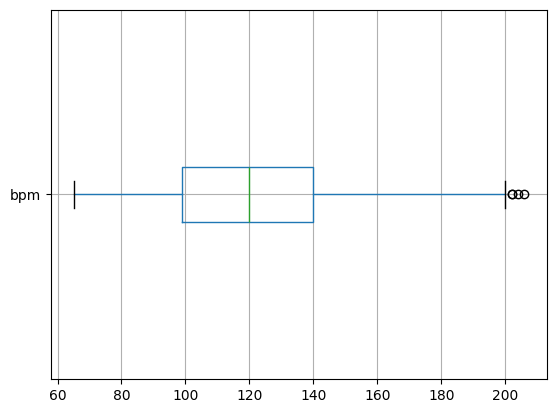

count   953.00
mean    122.40
std      27.98
min      65.00
25%      99.00
50%     120.00
75%     140.00
max     206.00
Name: bpm, dtype: float64

In [ ]:
'''Explore BPM data'''


raw_data.boxplot(column='bpm', vert=False)
plt.show()
raw_data['bpm'].describe()

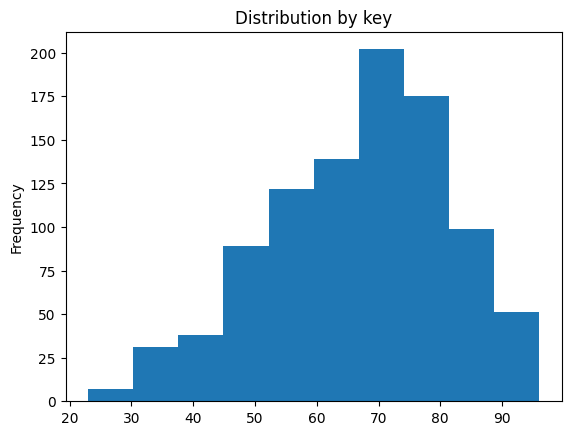

count   953.00
mean     66.97
std      14.63
min      23.00
25%      57.00
50%      69.00
75%      78.00
max      96.00
Name: danceability_%, dtype: float64

In [ ]:
raw_data['danceability_%'].plot(kind='hist', title='Distribution by key')
plt.show()
raw_data['danceability_%'].describe()

Part 2: Feature Engineering

In [ ]:
correlation = raw_data['average_streams_per_year'].corr(raw_data['in_apple_charts'])
correlation2 = raw_data['in_apple_playlists'].corr(raw_data['in_apple_charts'])
print("Correlation between Streams and Apple Charts:", correlation)
print("Correlation between Apple Playlists and Apple Charts:", correlation2)
#Justification of why we chose apple specifically, isn't soley based off streams/how many playlists have it see introducution to project for
#further explanation

Correlation between Streams and Apple Charts: 0.3829483122725129
Correlation between Apple Playlists and Apple Charts: 0.41452330571208174


In [ ]:
# Drop data that doesn't matter to us or that we have already processed into a seperate feature or that doesn't matter to us (avg_streams_per_year)
# because we have total streams and years since release
useable_data = raw_data.copy()
useable_data.drop(['in_shazam_charts','released_day', 'released_month', 'track_name', 'artist(s)_name','artist_count','bpm',
'in_spotify_charts', 'in_apple_charts', 'in_deezer_charts', 'in_deezer_playlists'], axis=1, inplace=True)


In [ ]:
#useable_data.to_csv('my_data.csv', index=False) # sanity check to get an overview of the data

Part 3: Classification

First, we will pick labels that we wish to use for our classification. We will drop our class_label_apple_char_category since we don't want to use this variable to predict our class (or else we could predict with 100% accuracy).

In [ ]:
#Picking features for our classification problem
classification_data = useable_data.copy()
classification_labels_data = classification_data['class_label_apple_chart_category'].copy()
classification_data.drop(['class_label_apple_chart_category'], axis=1, inplace=True)


print(classification_data.head())




   released_year  in_spotify_playlists    streams  in_apple_playlists key  \
0           2023                   553  141381703                  43   B   
1           2023                  1474  133716286                  48  C#   
2           2023                  1397  140003974                  94   F   
3           2019                  7858  800840817                 116   A   
4           2023                  3133  303236322                  84   A   

    mode  danceability_%  valence_%  energy_%  acousticness_%  \
0  Major              80         89        83              31   
1  Major              71         61        74               7   
2  Major              51         32        53              17   
3  Major              55         58        72              11   
4  Minor              65         23        80              14   

   instrumentalness_%  liveness_%  speechiness_%  season  stream_ranking  \
0                   0           8              4  summer             7

We will one hot encode our categorical variables to allow for our KNN, SVM, Neural Nets, and other models to have numerical variables to work on. Furthermore, we will scale our data from 0-1 as to disallow for some of our algorithms to value some features over others (such as KNN).

In [ ]:
# One hot encoding our data and normalizing our data

categorical_cols = list(classification_data.select_dtypes(include=['object']).columns)
numeric_cols = list(classification_data.select_dtypes(include=['int64', 'float64']).columns)
print(categorical_cols)
numeric_pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler(feature_range=(0, 1)))
])

categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ])

processed_data = preprocessor.fit_transform(classification_data)

processed_df = pd.DataFrame(processed_data)
print(processed_df.head())
print(processed_df.shape)
#processed_df.to_csv('processed_df.csv', index=False) # sanity check to get an overview of the data

['key', 'mode', 'season']
    0    1    2    3    4    5    6    7    8    9   ...   19   20   21   22  \
0 1.00 0.01 0.04 0.06 0.78 0.91 0.84 0.32 0.00 0.05  ... 0.00 0.00 0.00 0.00   
1 1.00 0.03 0.04 0.07 0.66 0.61 0.74 0.07 0.00 0.07  ... 0.00 0.00 0.00 0.00   
2 1.00 0.03 0.04 0.14 0.38 0.30 0.50 0.18 0.00 0.30  ... 1.00 0.00 0.00 0.00   
3 0.96 0.15 0.22 0.17 0.44 0.58 0.72 0.11 0.00 0.09  ... 0.00 0.00 0.00 0.00   
4 1.00 0.06 0.08 0.12 0.58 0.20 0.81 0.14 0.69 0.09  ... 0.00 0.00 0.00 0.00   

    23   24   25   26   27   28  
0 1.00 0.00 0.00 0.00 1.00 0.00  
1 1.00 0.00 0.00 1.00 0.00 0.00  
2 1.00 0.00 0.00 0.00 1.00 0.00  
3 1.00 0.00 0.00 0.00 1.00 0.00  
4 0.00 1.00 0.00 1.00 0.00 0.00  

[5 rows x 29 columns]
(953, 29)


Decision Trees

We will build a simple decision tree to see how accurate it performs on our data.

In [ ]:
#Normal Decision Tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier



X_train, X_test, y_train, y_test = train_test_split(processed_df, classification_labels_data, test_size=0.2)

clf = DecisionTreeClassifier(max_depth=5, min_samples_split=2)
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
print("Accuracy on test set:", accuracy)

cross_val_scores = cross_val_score(clf, processed_df, classification_labels_data, cv=5)
print("Cross-validation scores:", cross_val_scores)
print("Mean cross-validation score:", cross_val_scores.mean())


Accuracy on test set: 0.47643979057591623
Cross-validation scores: [0.31413613 0.40314136 0.34031414 0.48947368 0.52105263]
Mean cross-validation score: 0.4136235877652246


Our cross validation scores vary a lot across different folds. This is most likely due to random chance. To get a score better than ~41%, let's try tuning our hyperparameters.

In [ ]:
# Decision Tree with Nested CV

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
import numpy as np

param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10]
}

outer_cv = KFold(n_splits=5, shuffle=True)
inner_cv = KFold(n_splits=3, shuffle=True)

best_params = []

for train_index, test_index in outer_cv.split(processed_df):
    X_train_outer, X_test_outer = processed_df.iloc[train_index], processed_df.iloc[test_index]
    y_train_outer, y_test_outer = classification_labels_data.iloc[train_index], classification_labels_data.iloc[test_index]

    clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=inner_cv)
    clf.fit(X_train_outer, y_train_outer)

    best_params.append(clf.best_params_)

    accuracy = clf.score(X_test_outer, y_test_outer)
    print("Accuracy on outer test set:", accuracy)

print("Best parameters for each outer fold:", best_params)

Accuracy on outer test set: 0.5026178010471204
Accuracy on outer test set: 0.4607329842931937
Accuracy on outer test set: 0.4973821989528796
Accuracy on outer test set: 0.45263157894736844
Accuracy on outer test set: 0.5052631578947369
Best parameters for each outer fold: [{'max_depth': 3, 'min_samples_split': 2}, {'max_depth': 3, 'min_samples_split': 2}, {'max_depth': 7, 'min_samples_split': 5}, {'max_depth': 3, 'min_samples_split': 2}, {'max_depth': 3, 'min_samples_split': 2}]


Now that we performed a nested cross validation, our scores on average seem pretty good across our different folds meaning that hyperparameter tuning should yield good results. Let's run our model one final time on the entire dataset with hyperparameter tuning.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10]
}

clf = DecisionTreeClassifier()

grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(processed_df, classification_labels_data)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best cross-validation score:", best_score)

Best parameters: {'max_depth': 3, 'min_samples_split': 2}
Best cross-validation score: 0.43037751446679523


After hyperparameter tuning, our decision tree's accuracy increased by about 2%. This isn't the greatest and is most likely due to the fact that the hyperparameters we chose in our first test are similar to the ones that were found in our hyperparameter tuning.

Now we are trying some ensembling techniques. From a basic random forest classifier, we see that enembling gave us a mean cross validation score of 45%, which is a ~2% increase from just our normal decision tree classifier.

In [ ]:
#Random Forest Ensemble
from sklearn.ensemble import RandomForestClassifier


X_train, X_test, y_train, y_test = train_test_split(processed_df, classification_labels_data, test_size=0.2)
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
print("Accuracy on test set:", accuracy)

cross_val_scores = cross_val_score(clf, processed_df, classification_labels_data, cv=5)
print("Cross-validation scores:", cross_val_scores)
print("Mean cross-validation score:", cross_val_scores.mean())


Accuracy on test set: 0.5445026178010471
Cross-validation scores: [0.47643979 0.42408377 0.39790576 0.46315789 0.49473684]
Mean cross-validation score: 0.4512648112427666


We will try another RandomForest (which is the default for AdaBoost classifier), but boost is through AdaBoost. We see that our boosting model performed worse (with an accuracy of 37%). Notice that miniscule changes of accuracy like this may be due to random chance. It may also be the case that boosting may decrease our accuracy because our trees are trying to fit outliers, decreasing the accuracy of our overall tree.

In [ ]:
# AdaBoosting
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(processed_df, classification_labels_data, test_size=0.2)

clf = AdaBoostClassifier(n_estimators=10)
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
print("Accuracy on test set:", accuracy)

cross_val_scores = cross_val_score(clf, processed_df, classification_labels_data, cv=5)
print("Cross-validation scores:", cross_val_scores)
print("Mean cross-validation score:", cross_val_scores.mean())


Accuracy on test set: 0.3769633507853403
Cross-validation scores: [0.30366492 0.34554974 0.29842932 0.42631579 0.47894737]
Mean cross-validation score: 0.3705814273904657


Our GradientBoosting performed better than our AdaBoosting, with a mean cross validation of 44-45% in comparison to 37%.

In [ ]:
# Gradient Boosing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(processed_df, classification_labels_data, test_size=0.2)

clf = GradientBoostingClassifier(n_estimators=25)
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
print("Accuracy on test set:", accuracy)

cross_val_scores = cross_val_score(clf, processed_df, classification_labels_data, cv=5)
print("Cross-validation scores:", cross_val_scores)
print("Mean cross-validation score:", cross_val_scores.mean())


Accuracy on test set: 0.4816753926701571
Cross-validation scores: [0.40837696 0.47643979 0.36125654 0.47368421 0.50526316]
Mean cross-validation score: 0.4450041333700744


We will also try bagging decision trees. Note that this is different from RandomizedTrees because we only randomize the sampling of our datapoints, not the features we split on. This should be, and is less accurate than our randomized decision trees with a mean cross val score of 42% in comparison to 45%.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(processed_df, classification_labels_data, test_size=0.2)

# Using DecisionTreeClassifier as the base estimator for Bagging
tree = DecisionTreeClassifier()

clf = BaggingClassifier(estimator=tree, n_estimators=25)
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
print("Accuracy on test set:", accuracy)

cross_val_scores = cross_val_score(clf, processed_df, classification_labels_data, cv=5)
print("Cross-validation scores:", cross_val_scores)
print("Mean cross-validation score:", cross_val_scores.mean())


Accuracy on test set: 0.5287958115183246
Cross-validation scores: [0.38219895 0.42408377 0.37696335 0.43684211 0.47368421]
Mean cross-validation score: 0.41875447781758063


We will also try Extremelely Randomized Trees which will also randomize the thresholds that we split on. In our case, it seems like this extra layer of randomization decreased our accuracy down to 40%. It may be the case that when we picked random thresholds, we created suboptimal decision trees that decreased our accuracy.

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(processed_df, classification_labels_data, test_size=0.2)
clf = ExtraTreesClassifier(n_estimators=25)
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
print("Accuracy on test set:", accuracy)

cross_val_scores = cross_val_score(clf, processed_df, classification_labels_data, cv=5)
print("Cross-validation scores:", cross_val_scores)
print("Mean cross-validation score:", cross_val_scores.mean())


Accuracy on test set: 0.5026178010471204
Cross-validation scores: [0.39790576 0.34031414 0.39267016 0.44210526 0.45263158]
Mean cross-validation score: 0.4051253788922568


Other Classification methods

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(processed_df, classification_labels_data, test_size=0.2)

clf = MLPClassifier(hidden_layer_sizes=(1000, ), max_iter=10000)

clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
print("Accuracy on test set:", accuracy)

# cross_val_scores = cross_val_score(clf, processed_df, classification_labels_data, cv=5)
# print("Cross-validation scores:", cross_val_scores)
# print("Mean cross-validation score:", cross_val_scores.mean())


Accuracy on test set: 0.3769633507853403


Now we will see how neural nets perform in predicting our data. Our accuracy seems slightly worse compared to our decision tree accuracy in our first iteration. To better our accuracy, let's do some hyperparameter tuning.

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (500,), (1000,)],
    'max_iter': [1000, 5000, 10000]
}

outer_cv = KFold(n_splits=5, shuffle=True)
inner_cv = KFold(n_splits=3, shuffle=True)

best_params = []

for train_index, test_index in outer_cv.split(processed_df):
    X_train_outer, X_test_outer = processed_df.iloc[train_index], processed_df.iloc[test_index]
    y_train_outer, y_test_outer = classification_labels_data.iloc[train_index], classification_labels_data.iloc[test_index]

    clf = GridSearchCV(MLPClassifier(), param_grid, cv=inner_cv)
    clf.fit(X_train_outer, y_train_outer)

    best_params.append(clf.best_params_)

    accuracy = clf.score(X_test_outer, y_test_outer)
    print("Accuracy on outer test set:", accuracy)

print("Best parameters for each outer fold:", best_params)

Accuracy on outer test set: 0.41361256544502617
Accuracy on outer test set: 0.41361256544502617
Accuracy on outer test set: 0.34554973821989526
Accuracy on outer test set: 0.43157894736842106
Accuracy on outer test set: 0.4
Best parameters for each outer fold: [{'hidden_layer_sizes': (100,), 'max_iter': 10000}, {'hidden_layer_sizes': (50,), 'max_iter': 1000}, {'hidden_layer_sizes': (50,), 'max_iter': 1000}, {'hidden_layer_sizes': (50,), 'max_iter': 1000}, {'hidden_layer_sizes': (50,), 'max_iter': 1000}]


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (500,), (1000,)],
    'max_iter': [1000, 5000, 10000]
}

X_train, X_test, y_train, y_test = train_test_split(processed_df, classification_labels_data, test_size=0.2)

clf = GridSearchCV(MLPClassifier(), param_grid, cv=5)
clf.fit(X_train, y_train)

best_params = clf.best_params_
best_score = clf.best_score_

accuracy = clf.score(X_test, y_test)
print("Best parameters:", best_params)
print("Best cross-validation score:", best_score)
print("Accuracy on test set with best parameters:", accuracy)

Best parameters: {'hidden_layer_sizes': (50,), 'max_iter': 1000}
Best cross-validation score: 0.4684726522187823
Accuracy on test set with best parameters: 0.3769633507853403


Our neural net did not see much improvement after hyperparameter tuning. It may be the case that neural nets are just not a good fit.

PCA for SVM and KNN

Prior to performing SVM and KNN, we will want to perform PCA as these distance based metrics often suffer much more from the curse of dimentionality.

In [ ]:
from sklearn.decomposition import PCA


pca = PCA(n_components=.8)
processed_df_pca = pca.fit_transform(processed_df)
print(pd.DataFrame(processed_df_pca).head())
print(processed_df_pca.shape)
print(processed_df.shape)

     0     1     2     3     4     5     6     7     8     9     10    11
0 -0.53  0.00  0.36  0.89 -0.19 -0.51  0.05  0.36 -0.52 -0.53 -0.04  0.14
1 -0.61 -0.73 -0.43 -0.00  0.87 -0.11  0.02  0.03  0.06  0.02  0.02 -0.08
2 -0.58  0.04  0.39  0.83 -0.23  0.30 -0.12  0.57  0.63 -0.21 -0.13  0.04
3 -0.59  0.06  0.36  0.88 -0.17  0.31 -0.07 -0.08 -0.21 -0.10  0.48 -0.68
4  0.80 -0.76 -0.27 -0.08 -0.12  0.42 -0.08 -0.14 -0.21 -0.08  0.35 -0.77
(953, 12)
(953, 29)


Our first iteration of KNN was pretty bas, with an accuracy in the low 30%, only slightly better than random guessing (20%). This may because our data is more non-globular/is not clustered into its labels in a globular fashion. Lets try to improve this through hyperparameter tuning.

In [ ]:

from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(processed_df_pca, classification_labels_data, test_size=0.2)


clf = KNeighborsClassifier(weights='distance')

clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
print("Accuracy on test set with distance weighting:", accuracy)

cross_val_scores = cross_val_score(clf, processed_df_pca, classification_labels_data, cv=5)
print("Cross-validation scores with distance weighting:", cross_val_scores)
print("Mean cross-validation score with distance weighting:", cross_val_scores.mean())


Accuracy on test set with distance weighting: 0.34554973821989526
Cross-validation scores with distance weighting: [0.34554974 0.28795812 0.29842932 0.31578947 0.32105263]
Mean cross-validation score with distance weighting: 0.3137558556076054


After nested cross validation, we can already observe a significant increase in accuracy.

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance']
}

X_train, X_test, y_train, y_test = train_test_split(processed_df_pca, classification_labels_data, test_size=0.2)

outer_cv = KFold(n_splits=5, shuffle=True)
inner_cv = KFold(n_splits=3, shuffle=True)

best_params = []

for train_index, test_index in outer_cv.split(X_train):
    X_train_outer, X_test_outer = X_train[train_index], X_train[test_index]
    y_train_outer, y_test_outer = y_train.iloc[train_index], y_train.iloc[test_index]

    clf = GridSearchCV(KNeighborsClassifier(), param_grid, cv=inner_cv)
    clf.fit(X_train_outer, y_train_outer)

    best_params.append(clf.best_params_)

    accuracy = clf.score(X_test_outer, y_test_outer)
    print("Accuracy on outer test set:", accuracy)

print("Best parameters for each outer fold:", best_params)

Accuracy on outer test set: 0.4117647058823529
Accuracy on outer test set: 0.46405228758169936
Accuracy on outer test set: 0.35526315789473684
Accuracy on outer test set: 0.39473684210526316
Accuracy on outer test set: 0.4144736842105263
Best parameters for each outer fold: [{'n_neighbors': 7, 'weights': 'uniform'}, {'n_neighbors': 9, 'weights': 'uniform'}, {'n_neighbors': 5, 'weights': 'uniform'}, {'n_neighbors': 9, 'weights': 'uniform'}, {'n_neighbors': 7, 'weights': 'uniform'}]


After hyperparameter tuning, our accuracy shoots up to 41%, which is comparable to our normal decision tree classifiers.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance']
}

clf = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3)  # Perform grid search with 3-fold cross-validation
clf.fit(processed_df_pca, classification_labels_data)

best_params = clf.best_params_
best_score = clf.best_score_

print("Best parameters:", best_params)
print("Best cross-validation score:", best_score)

Best parameters: {'n_neighbors': 11, 'weights': 'uniform'}
Best cross-validation score: 0.4082098287800329


Now we will try SVM's. To account for the issue with linear classfiers, we can provide a kernel function to transform our data. Right of the bat, we can see a basic SVM performs fairly well with about 44% accuracy, which is similar to our randomized forest classifier.

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(processed_df_pca, classification_labels_data, test_size=0.2)

clf = SVC(kernel='rbf')

clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
print("Accuracy on test set:", accuracy)

cross_val_scores = cross_val_score(clf, processed_df_pca, classification_labels_data, cv=5)
print("Cross-validation scores:", cross_val_scores)
print("Mean cross-validation score:", cross_val_scores.mean())


Accuracy on test set: 0.387434554973822
Cross-validation scores: [0.43979058 0.41361257 0.46596859 0.42105263 0.46842105]
Mean cross-validation score: 0.44176908239184354


In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 1, 'scale'],
    'kernel': ['linear', 'rbf', 'poly']
}

X_train, X_test, y_train, y_test = train_test_split(processed_df_pca, classification_labels_data, test_size=0.2)

outer_cv = KFold(n_splits=5, shuffle=True)
inner_cv = KFold(n_splits=3, shuffle=True)

best_params = []

for train_index, test_index in outer_cv.split(X_train):
    X_train_outer, X_test_outer = X_train[train_index], X_train[test_index]
    y_train_outer, y_test_outer = y_train.iloc[train_index], y_train.iloc[test_index]

    clf = GridSearchCV(SVC(), param_grid, cv=inner_cv)
    clf.fit(X_train_outer, y_train_outer)

    best_params.append(clf.best_params_)

    accuracy = clf.score(X_test_outer, y_test_outer)
    print("Accuracy on outer test set:", accuracy)

print("Best parameters for each outer fold:", best_params)

Accuracy on outer test set: 0.41830065359477125
Accuracy on outer test set: 0.41830065359477125
Accuracy on outer test set: 0.4407894736842105
Accuracy on outer test set: 0.48026315789473684
Accuracy on outer test set: 0.47368421052631576
Best parameters for each outer fold: [{'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}, {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}]


After hyperparameter tuning, our SVMs perform better than any other classifier with accuracies over 46%.

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 1, 'scale'],
    'kernel': ['linear', 'rbf', 'poly']
}

outer_cv = KFold(n_splits=5, shuffle=True)
inner_cv = KFold(n_splits=3, shuffle=True)

clf = GridSearchCV(SVC(), param_grid, cv=inner_cv)
clf.fit(processed_df_pca, classification_labels_data)

best_params = clf.best_params_
best_score = clf.best_score_

print("Best parameters:", best_params)
print("Best cross-validation score:", best_score)

Best parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Best cross-validation score: 0.46065379706234416


Goal 2

Now we will do a regression to determine our stream rankings. To do so, we want to only consider features pre-release so we can potentially predict how new songs will perform. Because of this, we will drop features such as how many playlists is a song in.

In [ ]:
#Picking features for our regression problem
regression_data = useable_data.copy()
regression_labels_data = regression_data['stream_ranking'].copy()
regression_data.drop(['in_spotify_playlists', 'average_streams_per_year', 'stream_ranking', 'in_apple_playlists','class_label_apple_chart_category'], axis=1, inplace=True)


print(type(regression_labels_data))
#regression_data.to_csv('reg_data.csv', index=False) # sanity check to get an overview of the data




<class 'pandas.core.series.Series'>


We will proceed to one hot encode our categorical variables to make sense of them in a regression. Furthermore, we will also scale our data so our PCA won't favor some features over others.

In [ ]:
# One hot encoding our data and normalizing our data

categorical_cols = list(regression_data.select_dtypes(include=['object']).columns)
numeric_cols = list(regression_data.select_dtypes(include=['int64', 'float64']).columns)

numeric_pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ])

processed_reg_data = preprocessor.fit_transform(regression_data)

processed_reg_df = pd.DataFrame(processed_reg_data)
print(processed_reg_df.head())
#processed_reg_df.to_csv('processed_reg_df.csv', index=False) # sanity check to get an overview of the data

    0    1    2    3    4    5    6    7    8    9   ...   16   17   18   19  \
0 1.00 0.04 0.78 0.91 0.84 0.32 0.00 0.05 0.03 0.00  ... 0.00 0.00 0.00 0.00   
1 1.00 0.04 0.66 0.61 0.74 0.07 0.00 0.07 0.03 0.00  ... 0.00 0.00 0.00 0.00   
2 1.00 0.04 0.38 0.30 0.50 0.18 0.00 0.30 0.06 0.00  ... 1.00 0.00 0.00 0.00   
3 0.96 0.22 0.44 0.58 0.72 0.11 0.00 0.09 0.21 1.00  ... 0.00 0.00 0.00 0.00   
4 1.00 0.08 0.58 0.20 0.81 0.14 0.69 0.09 0.06 1.00  ... 0.00 0.00 0.00 0.00   

    20   21   22   23   24   25  
0 1.00 0.00 0.00 0.00 1.00 0.00  
1 1.00 0.00 0.00 1.00 0.00 0.00  
2 1.00 0.00 0.00 0.00 1.00 0.00  
3 1.00 0.00 0.00 0.00 1.00 0.00  
4 0.00 1.00 0.00 1.00 0.00 0.00  

[5 rows x 26 columns]


We perform a PCA because linear regression, which is a distance/residual based model, suffers from many dimensions.

In [ ]:
# PCA on Regression Frame

pca = PCA(n_components=.95)
processed_reg_df_pca = pca.fit_transform(processed_reg_df)
print(pd.DataFrame(processed_reg_df_pca).head())
print(processed_reg_df_pca.shape)
print(processed_reg_df.shape)

     0     1     2     3     4     5     6     7     8     9     10    11  \
0 -0.53 -0.01  0.36  0.89 -0.19 -0.50  0.05  0.36 -0.54 -0.52 -0.06  0.14   
1 -0.61  0.73 -0.43  0.00  0.87 -0.12  0.02  0.03  0.05  0.03  0.05 -0.07   
2 -0.58 -0.05  0.39  0.83 -0.23  0.30 -0.12  0.57  0.62 -0.22 -0.15  0.00   
3 -0.59 -0.06  0.36  0.88 -0.18  0.32 -0.07 -0.08 -0.20 -0.11  0.59 -0.59   
4  0.80  0.75 -0.28 -0.08 -0.13  0.43 -0.08 -0.14 -0.20 -0.08  0.48 -0.70   

     12    13    14    15    16  
0 -0.06  0.06  0.37  0.01 -0.05  
1  0.05 -0.03  0.06 -0.01 -0.04  
2  0.07 -0.09 -0.26 -0.04 -0.04  
3  0.05 -0.04  0.05  0.00 -0.10  
4  0.00 -0.19 -0.23 -0.07 -0.03  
(953, 17)
(953, 26)


Our first linear regression doesn't perform that badly. In fact, we get an MAE of 122, whereas our MAE would be 250 if we guessed 500 every time for our rankings.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(processed_reg_df, regression_labels_data, test_size=0.2)

model = LinearRegression()

model.fit(X_train, y_train)

predictions = model.predict(X_test)


mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)


#coefficients = pd.DataFrame({'Column': pd.DataFrame(processed_reg_df_pca).columns, 'Coefficient': model.coef_/100000})

Mean Absolute Error (MAE): 122.35471204188482


Let's visualize our predictions to see how we can increase the accuracy of our regression.

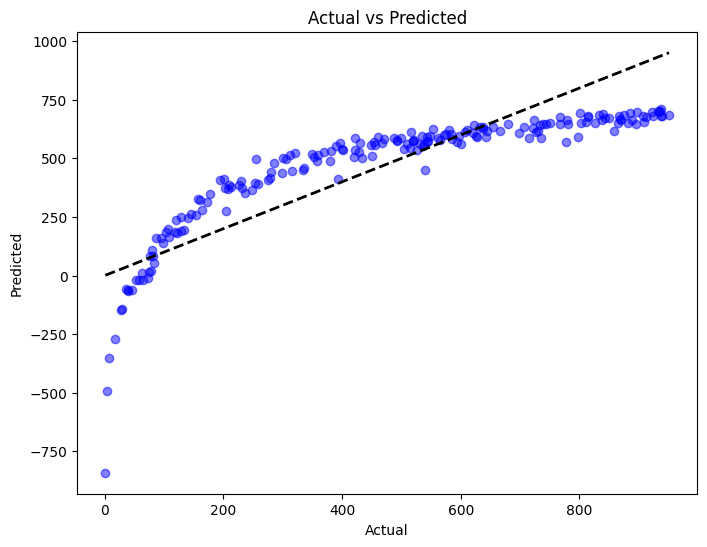

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, color='blue', alpha=0.5)  # Scatter plot of actual vs predicted
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line showing perfect prediction
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

There is a very clear pattern in the residuals of our data, so we try a non-linear regressions, specifically a logarithmic regression because that is what our data seems to fit

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(processed_reg_df, regression_labels_data, test_size=0.2)

# Generate polynomial features
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Transform target variable using logarithm
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)


model = LinearRegression()
model.fit(X_train_poly, y_train_log)

# Predict using the model
predictions_log = model.predict(X_test_poly)

# Transform predictions back to original scale
predictions = np.exp(predictions_log)

mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE) with Logarithmic Regression:", mae)

Mean Absolute Error (MAE) with Logarithmic Regression: 80.60906815347674


Already, we can see our accuracy of our logarithmic regressor heavily improved by curring our MAE down over 1/3. Let's visualize this as well.

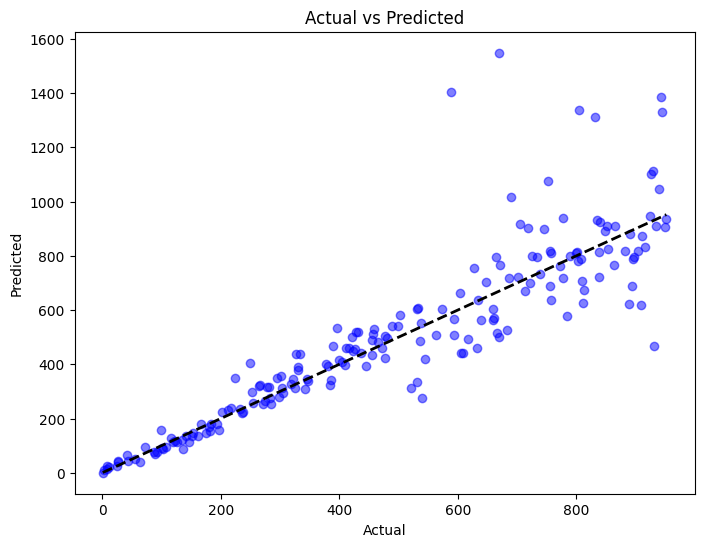

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, color='blue', alpha=0.5)  # Scatter plot of actual vs predicted
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line showing perfect prediction
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

Notice that we are very accurate in predicting the more popular songs while songs with lower ranking are predicted much worse. This may be due to the fact that logs decrease variance within our features with higher value, and it may be harder to predict their rankings when there is less variance to work with.

Just to see how our logarithmic regressor performs to a neural net, we'll also compare it to an MLP regressor.

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(processed_reg_df, regression_labels_data, test_size=0.2)

poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

model = MLPRegressor(hidden_layer_sizes=(10,), activation='relu', solver='adam', max_iter=1000)
model.fit(X_train_poly, y_train_log)

predictions_log = model.predict(X_test_poly)

predictions = np.exp(predictions_log)

mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)


Mean Absolute Error (MAE): 81.52950079332199


Our MAE is comparable to our logarithmic regressor.

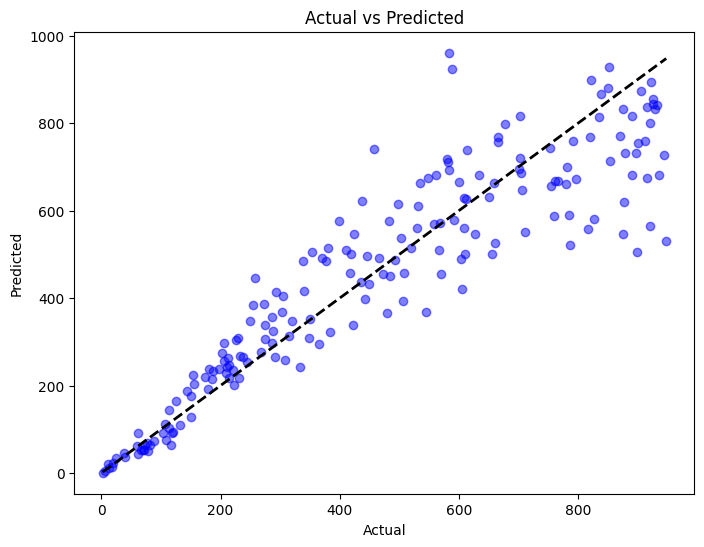

In [ ]:

plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, color='blue', alpha=0.5)  # Scatter plot of actual vs predicted
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line showing perfect prediction
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

We see the same issue occuring with our MLP regressor in comparison to our logarithmic regressor. Because of this, the MLP is likely overkill and the logarithmic regressor is therefore our best option for something like this.